# Logistic Regression

<p>The following notebook provides an example code of analyzing <b>Employee churn</b> using logistic regression. The dependent variable is <b>Churn (1-yes, 0-no)</b>. 
    
<br>The general sequence of steps for the analysis the following:
1. [Descriptive analysis](#pandas)
2. [Modelling (creating dummies, train test split)](#select)
3. [Logistic regression construction and interpretation (log odds, marginal effects)](#stats)
4. [Model evaluation(confusion matrix,classification report)](#stats1) 

 <h2>1.Descriptive analysis</h2> <a name="pandas"></a>

The initial data consists of 14999 observations of 10 variables.However, 3008 of them are duplicates, thus we drop them ending up with 11991 observations. Data overview hints that there are continuous (satisfaction_level,last_evaluation,average_montly_hours etc.), binary(promotion_last_5years,work_accident) and categorical (department, salary) features.
Employee churn is not evenly balanced between 0s and 1s. As the countplot and value counts show, only about 16% of employees are leaving and ~84% are staying.So we can use this info as a naive assumption for newcomers to decide whether they'll leave or stay. In other words, if the resulting score is more than the noted value, then our model will be not bad, otherwise-a bad one.

We also outlined several questions answers of can be observed visually.

    -Is there a relationship between satisfaction level, salary and churn?
    -What is the salary distribution by departments?
    -Which departments have the highest/lowest churn rate?
The visualization shows that employee churn is connected with the satisfaction level. The boxplot shows that employees who left are on average less satisfied with the job, regardless of the salary.
The highest paid department is sales and it is also the one having highest churn rate. Next comes technical and support departments.

In case of logistic regression when constructing a heatmap we are mostly interested in identifying correlations between independent variables, as the target is binary and correlation between Y and X-s is not represenative in this case.
The highest correlation is between average montly hours and number of projects, which is logical as the more projects there are, the more time you spend for their implementation. Next comes numbr of prjects and last evaluation, with 0.27 correlation 
coefficient.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import statsmodels.tools as sm
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, recall_score

In [2]:
#importing the data and making a dataframe
data=pd.read_csv("turnover.csv")

In [3]:
#data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
work_accident            14999 non-null int64
churn                    14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
#have a look at first rows of the dataframe
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,churn,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,churn,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [6]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 3008
Missing values: 0
Single valued columns: Index([], dtype='object')


In [7]:
#dropping duplicates
data.drop_duplicates(inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
satisfaction_level       11991 non-null float64
last_evaluation          11991 non-null float64
number_project           11991 non-null int64
average_montly_hours     11991 non-null int64
time_spend_company       11991 non-null int64
work_accident            11991 non-null int64
churn                    11991 non-null int64
promotion_last_5years    11991 non-null int64
department               11991 non-null object
salary                   11991 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


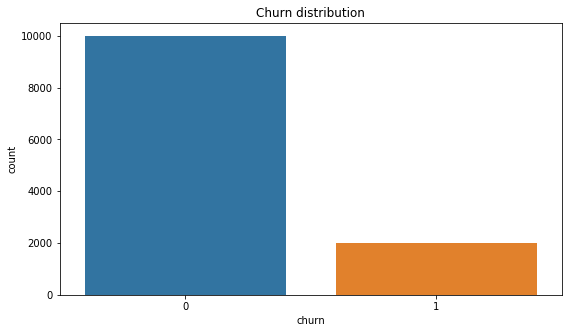

In [9]:
#let's visualise the distribution of churn
plt.figure(figsize=(9,5))
sns.countplot(data.churn)
plt.title("Churn distribution")
plt.show()

In [10]:
#lets count the benchmark for employee churn
data.churn.value_counts()/len(data)*100

0    83.39588
1    16.60412
Name: churn, dtype: float64

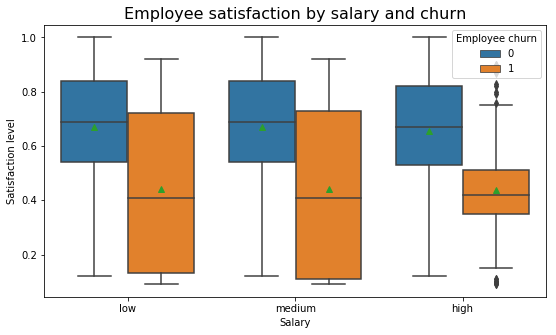

In [11]:
#Let's see the relationship of salary and satisfaction level
plt.figure(figsize=(9,5))
sns.boxplot(x="salary", y="satisfaction_level", data=data, showmeans=True, hue="churn")
plt.legend(title='Employee churn', loc='upper right')
plt.xlabel("Salary")
plt.ylabel("Satisfaction level")
plt.title("Employee satisfaction by salary and churn",fontdict={"fontsize":16})
plt.show()


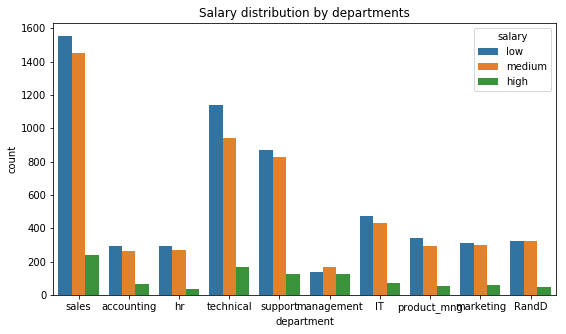

In [12]:
plt.figure(figsize=(9,5))
sns.countplot(data.department, hue=data.salary)
plt.title("Salary distribution by departments")
plt.show()

In [13]:
#confirming previous plot info
data.department[data.salary=="high"].value_counts()

sales          237
technical      166
management     128
support        126
IT              71
accounting      63
marketing       62
product_mng     52
RandD           47
hr              38
Name: department, dtype: int64

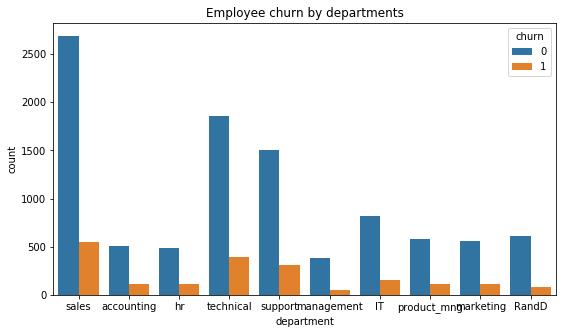

In [14]:
plt.figure(figsize=(9,5))
sns.countplot(data.department, hue=data.churn)
plt.title("Employee churn by departments")
plt.show()

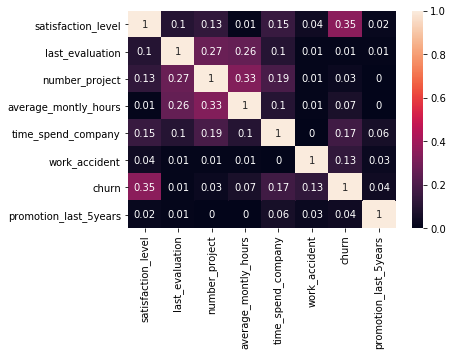

In [15]:
sns.heatmap(data.corr().abs().round(2),annot=True)
plt.show()

<h1> 2. Modelling (creating dummies, train test split)</h1> <a name="select"> </a>

We dummify the categorical variables, separate X and Y and split the data into train and test sets

In [16]:
#Let's create dummy variables 
data=pd.get_dummies(data,drop_first=True)

In [17]:
#separating X and Y
Y=data["churn"]
X=data.drop("churn",axis=1)

In [18]:
#as we are going to use not formula but X and Y data in the logit function, 
#so we need to add the intercept to data (X) manually
X=sm.add_constant(X)

In [19]:
#let's split X and Y data into test and train datasets, test data is 25% of overall data
#splitting the data into train and test sets
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

<h1> 3. Logistic regression construction and interpretation (log odds, marginal effects)</h1> <a name="stats"> </a>

We will construct the model based on statsmodels.api library, meaning will fit the data on training set and evaluate both 
for training and testing sets.

In [20]:
#constructing the logit model
model=Logit(Y0,X0)
#fitting the model
results=model.fit()

Optimization terminated successfully.
         Current function value: 0.358804
         Iterations 8


In [21]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 8993
Model:                          Logit   Df Residuals:                     8974
Method:                           MLE   Df Model:                           18
Date:                Thu, 17 Oct 2019   Pseudo R-squ.:                  0.2021
Time:                        04:55:56   Log-Likelihood:                -3226.7
converged:                       True   LL-Null:                       -4044.1
                                        LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.5485      0.288     -8.854      0.000      -3.113      -1.984
satisfaction_level        -3.8902      0.138    -28.114      0.000      -4.161      -3.619
last_evaluation            0.7589      0.208      3.657      0.000       0.352       1.166
number_project            -0.2677      0.030     -8.982      0.000      -0.326      -0.209
average_montly_hours       0.0040      0.001      5.651      0.000       0.003       0.005
time_spend_company         0.3161      0.023     13.512      0.000       0.270       0.362
work_accident             -1.3721      0.126    -10.878      0.000      -1.619      -1.125
promotion_last_5years     -1.5036      0.445     -3.377      0.001      -2.376      -0.631
department_RandD          -0.4277      0.188     -2.273      0.023      -0.797      -0.059
department_accounting     -0.0025      0.178     -0.014      0.989      -0.351       0.346
department_hr              0.1573      0.173      0.908      0.364      -0.182       0.497
department_management     -0.2083      0.216     -0.966      0.334      -0.631       0.214
department_marketing       0.1637      0.171      0.958      0.338      -0.171       0.499
department_product_mng     0.0353      0.172      0.205      0.837      -0.301       0.372
department_sales           0.0534      0.126      0.423      0.673      -0.194       0.301
department_support         0.1137      0.137      0.829      0.407      -0.155       0.382
department_technical       0.0738      0.133      0.555      0.579      -0.187       0.334
salary_low                 2.0509      0.197     10.412      0.000       1.665       2.437
salary_medium              1.5839      0.198      8.001      0.000       1.196       1.972
==========================================================================================
"""

- <b> For a one-unit increase in satisfaction_level we expect on average a -3.8902 decrease in the log-odds of churn, holding all other independent variables constant.</b>
- <b> For employees with low salaries, we expect on average a 2.0509  increase in the log-odds of the dependent variable churn compared to the employees with high salaries.</b>

As we want to interpret probabilites, let's get marginal effects.

In [22]:
results.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  churn
Method:                          dydx
At:                           overall
==========================================================================================
                            dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
satisfaction_level        -0.4307      0.013    -32.405      0.000      -0.457      -0.405
last_evaluation            0.0840      0.023      3.665      0.000       0.039       0.129
number_project            -0.0296      0.003     -9.044      0.000      -0.036      -0.023
average_montly_hours       0.0004   7.83e-05      5.684      0.000       0.000       0.001
time_spend_company         0.0350      0.003     13.893      0.000       0.030       0.040
work_accident             -0.1519      0.014    -11.013      0.000      -0.179      -0.125
promotion_last_5years     -0.1665      0.049     -3.380      0.001      -0.263      -0.070
department_RandD          -0.0474      0.021     -2.275      0.023      -0.088      -0.007
department_accounting     -0.0003      0.020     -0.014      0.989      -0.039       0.038
department_hr              0.0174      0.019      0.908      0.364      -0.020       0.055
department_management     -0.0231      0.024     -0.967      0.334      -0.070       0.024
department_marketing       0.0181      0.019      0.958      0.338      -0.019       0.055
department_product_mng     0.0039      0.019      0.205      0.837      -0.033       0.041
department_sales           0.0059      0.014      0.423      0.673      -0.022       0.033
department_support         0.0126      0.015      0.829      0.407      -0.017       0.042
department_technical       0.0082      0.015      0.555      0.579      -0.021       0.037
salary_low                 0.2271      0.022     10.529      0.000       0.185       0.269
salary_medium              0.1753      0.022      8.048      0.000       0.133       0.218
==========================================================================================
"""

- <b> An Incremental increase in satisfaction level will decrease the probability of churn on average by 43% when other factors are held constant.</b>
- <b>Employees with low salary have on average 22.71% higher probability of churn compared to employees with high salaries.</b>

<h1> 3. Model evaluation(confusion matrix,classification report)</h1> <a name="stats1"> </a>

In order to evaluate the model, we will use several methods. First,we will calculate classification metrics by hand. For that purpose we will use confusion matrix based on <code>pred_table()</code> to observe the different results of predictions based on the threshold.
Next, we will use <code> confusion_matrix()</code> from sklearn library, to make calculations easier.
Last, we will use classification report.
Note that in order to calculate the metrics for test data we will need to:
   -to predict probabilities for test data,
   -based on the predicted probabilities to classify observations into "1" and "0",
   -construct confusion matrix for the predicted classes and true values of dependent variables


<img src="conf.png" style="height:200px">

<b> Precision=TP/TP+FP</b> Out of all the positive classes we have predicted correctly, how many are actually positive.

<b>Recall(Sensitivity)=TP/TP+FN </b>  Out of all the positive classes, how much we predicted correctly.

<b>Specificity=TN/TN+FP </b>  Out of all the positive classes, how much we predicted correctly.

<b>F1 Score:</b>This is a harmonic mean (2xPrecisionxRecall/Precision+Recall) of the true positive rate (recall) and precision. 

In [23]:
#default treshold is 0.5 
results.pred_table().T

array([[7188., 1169.],
       [ 311.,  325.]])

In [24]:
#let's change treshold from 0.5 to 0.7
results.pred_table(0.7).T

array([[7428., 1478.],
       [  71.,   16.]])

It can be seen that after changing treshold, we predicted more 0 (7428) and less 1 (16).

In [25]:
#let's calculate overall accuracy, recall and specificity by hand for the train set
Accuracy=(7188+325)/(7188+1169+311+325)
Recall=325/(325+1169)
Specificity=7188/(7188+311)
print("Accuracy:",Accuracy)
print("Recall:",Recall)
print("Specificity:",Specificity)

Accuracy: 0.8354275547648171
Recall: 0.2175368139223561
Specificity: 0.958527803707161


In [26]:
#now let's make everything easier
#predicting for train and test data
Y1_logit=results.predict(sm.add_constant(X1))
Y0_logit=results.predict(X0)

In [27]:
#converting probabilities into labels
Y1_logit=np.where(Y1_logit>=0.5,1,0)
Y0_logit=np.where(Y0_logit>=0.5,1,0)

In [28]:
#Using confusion matrix for train and test data
cm_train=confusion_matrix(Y0,Y0_logit).T

In [29]:
#let's calculate overall accuracy, recall and specificity for train data
print("Accuracy_train:", (cm_train[0,0]+cm_train[1,1])/len(Y0))
print("Sensitivity_train:",cm_train[1,1]/(cm_train[1,1]+cm_train[1,0]))
print("Specificity_train:",cm_train[0,0]/(cm_train[0,0]+cm_train[0,1]))

Accuracy_train: 0.8354275547648171
Sensitivity_train: 0.5110062893081762
Specificity_train: 0.8601172669618284


In [30]:
#confusion matrix for the test data
cm_test=confusion_matrix(Y1,Y1_logit).T

In [31]:
#let's calculate overall accuracy, recall and specificity for train data
print("Accuracy_test:", (cm_test[0,0]+cm_test[1,1])/len(Y1))
print("Sensitivity_test:",cm_test[1,1]/(cm_test[1,1]+cm_test[1,0]))
print("Specificity_test:",cm_test[0,0]/(cm_test[0,0]+cm_test[0,1]))


Accuracy_test: 0.8348899266177452
Sensitivity_test: 0.5052631578947369
Specificity_test: 0.8571937321937322


In [32]:
#calculating using classification report
print("Logistic Regression Train:")
print(classification_report(Y0,Y0_logit))

print("Logistic Regression Test:")
print(classification_report(Y1,Y1_logit))

Logistic Regression Train:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7499
           1       0.51      0.22      0.31      1494

   micro avg       0.84      0.84      0.84      8993
   macro avg       0.69      0.59      0.61      8993
weighted avg       0.80      0.84      0.81      8993

Logistic Regression Test:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2501
           1       0.51      0.19      0.28       497

   micro avg       0.83      0.83      0.83      2998
   macro avg       0.68      0.58      0.59      2998
weighted avg       0.80      0.83      0.80      2998



We can see that although the metrics are good for 0s, our model is not doing a good job when predicting 1s. This may be a problem 
of unbalanced data, not using cross-validation and hyperparameter tuning.